In [1]:
DETECTION_THRESHOLD = 0.05
iou_thr = 0.4
imgSize = 512
edge_thr = 5
DATA_ROOT_PATH = '../input/vinbigdata-original-image-dataset/vinbigdata/test'
WEIGHT_PATH = '../input/vinbigdata-public/model_state_epoch_7.pth'

In [2]:
!pip install -qq pydicom
!pip install -qq imagesize
!pip install -qq map-boxes
!pip install -qq ensemble_boxes
!pip install -qq git+https://github.com/albumentations-team/albumentations

In [3]:
import pandas as pd
import numpy as np
import cv2
import os
import re
import time
import pydicom
import random
import zipfile
from PIL import Image
from glob import glob
from tqdm import *
from datetime import datetime
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
import torch
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SequentialSampler, RandomSampler
from matplotlib import pyplot as plt
from ensemble_boxes import *
from map_boxes import mean_average_precision_for_boxes
import multiprocessing
import imagesize

import warnings
warnings.filterwarnings("ignore")

/opt/conda/lib/python3.7/site-packages/Cython/Compiler/Main.py:369: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /opt/conda/lib/python3.7/site-packages/map_boxes/compute_overlap.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


In [4]:
SEED = 1312
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
seed_everything(SEED)

In [5]:
def get_valid_transforms():
    return A.Compose([
            A.LongestMaxSize(max_size=imgSize),
            A.PadIfNeeded(min_height=imgSize, min_width=imgSize, p=1.0, border_mode=cv2.BORDER_CONSTANT),
            #A.Resize(height=imgSize, width=imgSize, p=1.0),
            ToTensorV2(p=1.0),
        ], p=1.0)

In [6]:
image_dir = "../input/vinbigdata-chest-xray-abnormalities-detection/test"
class DatasetRetriever(Dataset):

    def __init__(self, image_ids, transforms=None):
        super().__init__()
        self.image_ids = image_ids
        self.transforms = transforms
        
    def __getitem__(self, index: int):
        image_id = self.image_ids[index]
        dicom = pydicom.dcmread(f"{image_dir}/{image_id}.dicom")
        image = dicom.pixel_array
        if "PhotometricInterpretation" in dicom:
            if dicom.PhotometricInterpretation == "MONOCHROME1":
                image = np.amax(image) - image

        image = np.stack([image, image, image])
        image = image.astype('float32')
        image = image - image.min()
        image = image / image.max()
        image = image.transpose(1, 2, 0)
        
        if self.transforms:
            sample = {'image': image}
            sample = self.transforms(**sample)
            image = sample['image']
        return image, image_id

    def __len__(self) -> int:
        return self.image_ids.shape[0]

In [7]:
image_ids = glob(os.path.join('../input/vinbigdata-chest-xray-abnormalities-detection/test', "*.dicom"))
image_ids = [image_id.split('/')[-1].split('.')[0] for image_id in image_ids]
dataset = DatasetRetriever(image_ids = np.array(image_ids), transforms = get_valid_transforms())

def collate_fn(batch):
    return tuple(zip(*batch))

data_loader = DataLoader(dataset, batch_size=4, shuffle=False, num_workers=4, drop_last=False, collate_fn=collate_fn)

In [8]:
net = torchvision.models.detection.fasterrcnn_resnet50_fpn(
    pretrained=False,
    pretrained_backbone=False,
    min_size=512,
    max_size=853
)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

num_classes = 15

# get number of input features for the classifier
in_features = net.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
net.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

# Load the trained weights
net.load_state_dict(torch.load(WEIGHT_PATH, map_location=device))
net.eval()

x = net.to(device)

In [9]:
def make_predictions(images, score_threshold=0.5):
    images = list(image.to(device) for image in images)
    predictions = []
    with torch.no_grad():
        det = net(images)
        for i in range(len(images)):
            _, h,w = images[i].cpu().detach().numpy().shape
            boxes = det[i]['boxes'].detach().cpu().numpy()
            scores = det[i]['scores'].detach().cpu().numpy()
            labels = det[i]['labels'].detach().cpu().numpy()
            
            
            indexes = np.where(scores > score_threshold)[0]
            boxes = boxes[indexes]
            scores = scores[indexes]
            labels = labels[indexes]
            
            indexes = np.where(labels < 15)[0]
            boxes = boxes[indexes]
            scores = scores[indexes]
            labels = labels[indexes]
            
            indexes = np.where(boxes[:,0] > 0+edge_thr)[0]
            boxes = boxes[indexes]
            scores = scores[indexes]
            labels = labels[indexes]
            
            indexes = np.where(boxes[:,1] > 0+edge_thr)[0]
            boxes = boxes[indexes]
            scores = scores[indexes]
            labels = labels[indexes]
            
            indexes = np.where(boxes[:,2] < imgSize-edge_thr)[0]
            boxes = boxes[indexes]
            scores = scores[indexes]
            labels = labels[indexes]
            
            indexes = np.where(boxes[:,3] < imgSize-edge_thr)[0]
            boxes = boxes[indexes]
            scores = scores[indexes]
            labels = labels[indexes]
            
            boxes[:, 0] = (boxes[:, 0] / w)
            boxes[:, 1] = (boxes[:, 1] / h)
            boxes[:, 2] = (boxes[:, 2] / w)
            boxes[:, 3] = (boxes[:, 3] / h)
            
            predictions.append({
                'boxes': boxes,
                'scores': scores,
                'labels': labels
            })
    return predictions

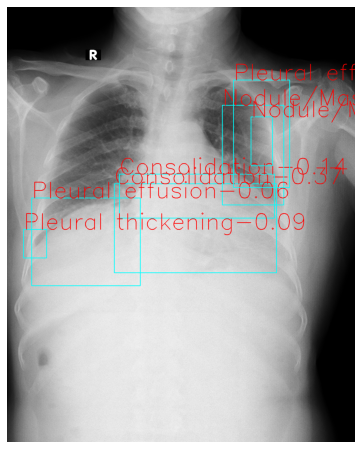

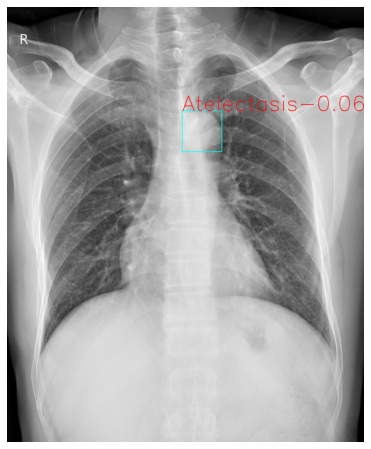

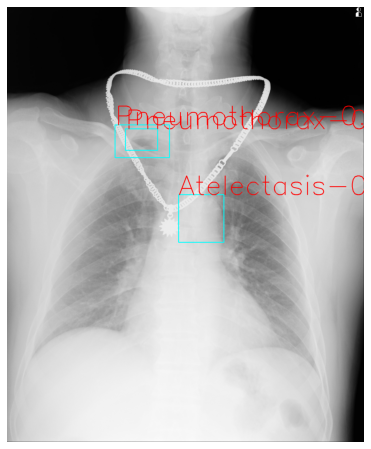

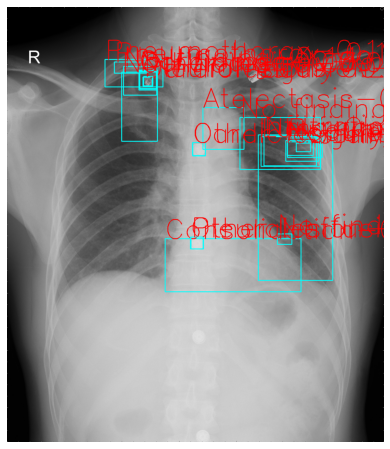

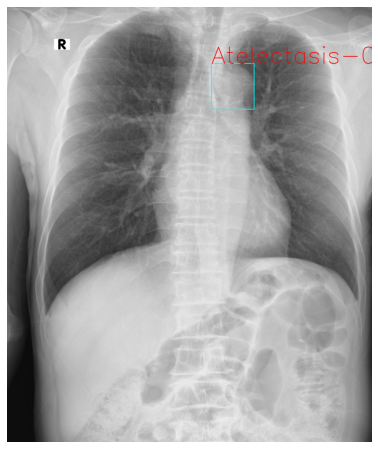

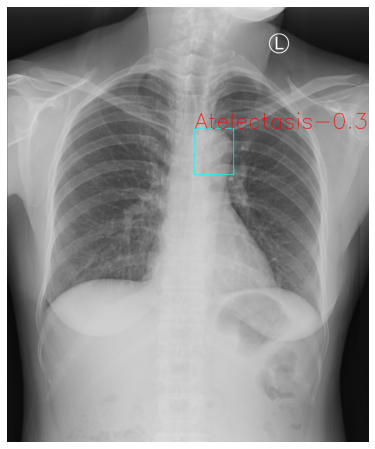

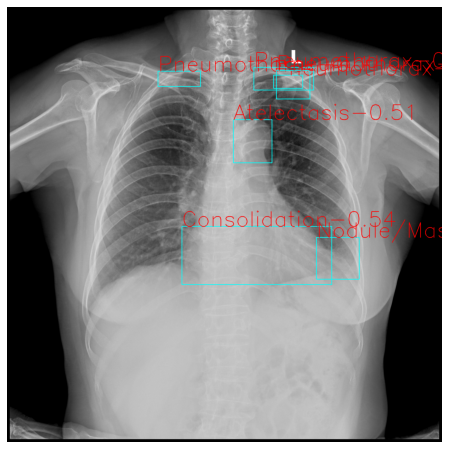

In [10]:
mapping = {0: 'Aortic enlargement', 1: 'Atelectasis', 2: 'Calcification', 3: 'Cardiomegaly', 4: 'Consolidation', 5: 'ILD',6: 'Infiltration', 7: 'Lung Opacity', 
           8: 'Nodule/Mass', 9: 'Other lesion', 10: 'Pleural effusion', 11: 'Pleural thickening',12: 'Pneumothorax', 13: 'Pulmonary fibrosis', 14: 'No finding'}

font = cv2.FONT_HERSHEY_SIMPLEX
fontScale = 5
thickness = 3
color = (1, 0, 0)

for j, (images, image_ids) in enumerate(data_loader):
    predictions = make_predictions(images, score_threshold=DETECTION_THRESHOLD)
    for i in range(len(predictions)):
        prediction = predictions[i]
        image_id = image_ids[i]
        
        if (len(prediction['scores'])>0):
            fig, ax = plt.subplots(1, 1, figsize=(8, 8))
            
            w, h = imagesize.get(f'{DATA_ROOT_PATH}/{image_id}.jpg')
            image = cv2.imread(f'{DATA_ROOT_PATH}/{image_id}.jpg', cv2.IMREAD_COLOR).copy().astype(np.float32)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
            image /= 255.0
            
            boxes, scores, labels = prediction['boxes'], prediction['scores'], prediction['labels']
            boxes, scores, labels = weighted_boxes_fusion([boxes], [scores], [labels], 
                                                          weights=None, 
                                                          iou_thr=iou_thr,
                                                          skip_box_thr=DETECTION_THRESHOLD)
            
            if (w > h):
                boxes[:, 0] = (boxes[:, 0] * w)
                boxes[:, 1] = (boxes[:, 1] * w) - (0.0 + w-h)/2
                boxes[:, 2] = (boxes[:, 2] * w)
                boxes[:, 3] = (boxes[:, 3] * w) - (0.0 + w-h)/2
            else:
                boxes[:, 0] = (boxes[:, 0] * h) - (0.0 + h-w)/2
                boxes[:, 1] = (boxes[:, 1] * h) 
                boxes[:, 2] = (boxes[:, 2] * h) - (0.0 + h-w)/2
                boxes[:, 3] = (boxes[:, 3] * h) 
        
            boxes = boxes.astype(np.int32)
            boxes[:, 0] = boxes[:, 0].clip(min=0, max=w-1)
            boxes[:, 2] = boxes[:, 2].clip(min=0, max=w-1)
            boxes[:, 1] = boxes[:, 1].clip(min=0, max=h-1)
            boxes[:, 3] = boxes[:, 3].clip(min=0, max=h-1)
            for score, box, label in zip(scores, boxes, labels):
                cv2.rectangle(image, (box[0], box[1]), (box[2], box[3]), (0, 1, 1), thickness)
                cv2.putText(image, mapping[label] + "-" + str(round(score, 2)), (box[0], box[1]),
                        font, fontScale, color, thickness, cv2.LINE_AA)

            ax.set_axis_off()
            ax.imshow(image)
            plt.show()
    if j >= 1:
        break

In [11]:
df = {'image_id': [],
      'class_id': [],
      'score':[],
      'x_min': [],
      'x_max': [],
      'y_min': [],
      'y_max': []}
for images, image_ids in tqdm(data_loader):
    predictions = make_predictions(images, score_threshold=DETECTION_THRESHOLD)
    
    for i in range(len(predictions)):
        prediction = predictions[i]
        image_id = image_ids[i]
        w, h = imagesize.get(f'{DATA_ROOT_PATH}/{image_id}.jpg')
        
        boxes, scores, labels = prediction['boxes'], prediction['scores'], prediction['labels']
        boxes, scores, labels = weighted_boxes_fusion([boxes/imgSize], [scores], [labels], 
                                                          weights=None, 
                                                          iou_thr=iou_thr,
                                                          skip_box_thr=DETECTION_THRESHOLD)
        
        df['image_id'] += [image_id]*len(labels)
        df['class_id'] += labels.tolist()
        df['score'] += scores.tolist()
        df['x_min'] += boxes[:, 0].tolist()
        df['y_min'] += boxes[:, 1].tolist()
        df['x_max'] += boxes[:, 2].tolist()
        df['y_max'] += boxes[:, 3].tolist()

  0%|          | 0/750 [00:14<?, ?it/s]


In [12]:
!rm -rf omegaconf
!rm -rf timm-efficientdet-pytorch

In [13]:
import pandas as pd
from tqdm import *
def to_submission(df, sample_file='sample_submission.csv', filename=None, trick=True):
    '''
    df: output dataframe
    sample_file: sample_submission file (to get image_id)
    filename: to csv file name
    trick: add class 14 to all images
    
    return a dataframe
    '''
    
    ss = pd.read_csv(sample_file)
    d = {i:[] for i in ss['image_id'].values.tolist()}
    sizemap = {i:(w,h) for i,w,h in zip(ss['image_id'].values.tolist(), ss['width'].values.tolist(), ss['height'].values.tolist())}
    trick_string = {i:' 14 '+str(s)+' 0 0 1 1' for i,s in zip(ss['image_id'].values.tolist(), ss['class14prob'].values.tolist())}
    
    image_id = []
    PredictionString = []
    for i in trange(len(df['image_id'].values.tolist())):
        w,h = sizemap[df['image_id'][i]]
        d[df['image_id'][i]].append(" ".join(map(str, [df['class_id'][i], df['score'][i], round(float(df['x_min'][i])*w), round(float(df['y_min'][i])*h), round(float(df['x_max'][i])*w), round(float(df['y_max'][i])*h)] )))
        
    for (k,v) in d.items():
        image_id.append(k)
        if (len(v) == 0): #case 14 1 0 0 1 1 not in df
            PredictionString.append(trick_string[k])
        elif (len(v) == 1 and v[0].startswith("14 ")): #case 14 x 0 0 1 1 in df
            PredictionString.append(" ".join(v[0].split()[:2])+' 0 0 1 1')
        else:
            PredictionString.append(" ".join(v) + int(trick)*trick_string[k])
    result = pd.DataFrame()
    result['image_id'] = image_id
    result['PredictionString'] = PredictionString
    
    result.sort_values('image_id', ignore_index=True,  inplace=True)
    
    if (filename):
        result.to_csv(filename, index = False)
    return result

In [15]:
submission = to_submission(pd.DataFrame().from_dict(df), sample_file = '../input/2021-vin-2class/sample_submission.csv')
submission.head(10)

100%|██████████| 11/11 [00:00<00:00, 10016.79it/s]


,image_id,PredictionString
0,002a34c58c5b758217ed1f584ccbcfe9,14 0.98667386 0 0 1 1
1,004f33259ee4aef671c2b95d54e4be68,14 0.9627654659999999 0 0 1 1
2,008bdde2af2462e86fd373a445d0f4cd,14 0.06030032 0 0 1 1
3,009bc039326338823ca3aa84381f17f1,14 0.876201349 0 0 1 1
4,00a2145de1886cb9eb88869c85d74080,14 0.34599351899999997 0 0 1 1
5,00b7e6bfa4dc1fe9ddd0ce74743e38c2,14 0.198367283 0 0 1 1
6,011295e0bcdc7636569ab73bfdcc4450,14 0.986467935 0 0 1 1
7,013c169f9dad6f1f6485da961b9f7bf2,14 0.362230472 0 0 1 1
8,01431a2618c0ace741e4e270a37e20b9,14 0.053823829000000004 0 0 1 1
9,0168eb925aa6f28a78b16134792f5d0e,14 0.982547793 0 0 1 1
